# First Stage development about pre-process
Shadab Alam

In [1]:
import Pkg; 
#Pkg.add("Plots")
#Pkg.add("ExtendableGrids")
#Pkg.add("LoopVectorization")
#Pkg.add("BenchmarkTools")
#Pkg.add("SkyCoords")
#Pkg.add("FITSIO")
#Pkg.add("YAML")
#Pkg.add("PlotlyJS")
#Pkg.add("JLD2")
#Pkg.add("Formatting")
Pkg.add("Printf")

    Updating registry at `~/.julia/registries/General.toml`
┌ Warning: could not download https://pkg.julialang.org/registries
│   exception = Downloads.RequestError("https://pkg.julialang.org/registries", 28, "Connection timeout after 30000 ms", Downloads.Response(nothing, "https://pkg.julialang.org/registries", 0, "", Pair{String, String}[]))
└ @ Pkg.Registry /private/tmp/julia-20211223-81055-17amu57/julia-1.7.1/usr/share/julia/stdlib/v1.7/Pkg/src/Registry/Registry.jl:82
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [2]:
using ExtendableGrids
using Plots
using LoopVectorization
using BenchmarkTools
using SkyCoords
using FITSIO
using YAML
using JLD2
using Formatting
using Printf

In [13]:
function dotProd(x, y)
           prod = zero(eltype(x))
           for i in eachindex(x, y)
               prod += x[i] * y[i]
           end
           prod
end
  
# using the simd macro
function dotProd_simd(x, y)
           prod = zero(eltype(x))
          @simd for i in eachindex(x, y)
               prod += x[i] * y[i]
           end
           prod
end
  
# using the avx macro
using LoopVectorization
function dotProd_avx(x, y)
           prod = zero(eltype(x))
           @avx for i in eachindex(x, y)
               prod += x[i] * y[i]
           end
           prod
end

dotProd_avx (generic function with 1 method)

In [14]:

  
# generating random data
x = rand(10 ^ 3);
y = rand(10 ^ 3);

In [15]:
# benchmark the function without any macro
@btime dotProd(x, y) 

  925.143 ns (1 allocation: 16 bytes)


255.57844694496956

In [8]:
# benchmark the function with simd macro
@btime dotProd_simd(x, y)

  869.625 ns (1 allocation: 16 bytes)


253.7418067943018

In [9]:
# benchmark the function with avx macro
@btime dotProd_avx(x, y)

  81.930 ns (1 allocation: 16 bytes)


253.7418067943018

In [10]:
# generating random data
x = rand(10,3);
y = rand(10 ,3);
for i in eachindex(x, y)
    print(i,' ',x[i],' ',y[i],'\n')
end

1 0.2762578895186938 0.39428626226381414
2 0.3338572126797159 0.38693616519565843
3 0.07699442231501452 0.5367734692243502
4 0.7674402643000122 0.31503910075957964
5 0.17678358796860416 0.28482316140650155
6 0.2558514861637564 0.8237405499770194
7 0.10093843899879418 0.01517337730046009
8 0.14996486117054064 0.27388226939526894
9 0.7786705735745274 0.19928692366925094
10 0.5025700598250531 0.01895298434883297
11 0.5595613035875862 0.4298322257940166
12 0.8652824544027258 0.22992557890104015
13 0.17720501171858394 0.2404017158305718
14 0.888247473838573 0.4809858223842687
15 0.1430823393471421 0.18360506626159223
16 0.00923685646786665 0.8270731097302153
17 0.19101432764937787 0.14525484603591465
18 0.09202500799059554 0.11162735723235251
19 0.10186339978773651 0.8906186458635648
20 0.5704059605846588 0.9228668325467011
21 0.49226816435584864 0.5194798359753474
22 0.6208311217584113 0.8690765925030246
23 0.9798928605184971 0.4932145210213068
24 0.09772944693280028 0.9475988826014654
25 

In [214]:
# Different forms of costheta function
function costheta_uv(u,varr)
    #=Evaluates the cosine of theta between a fixe vector u and and array of vector v
    Returns the dot product of the u with each vector in v
    =#
    a = fill(zero(eltype(varr)),size(varr,1) )
    for k in indices(varr, 2)
        for j in indices(varr, 1)
            a[j] += u[k] * varr[j, k]
        end
    end
    return a
end

function costheta_uv!(u,varr,rdist)
    #=Evaluates the cosine of theta between a fixe vector u and and array of vector v
    Returns the dot product of the u with each vector in v
    Inplace in rdist
    =#
    #rdist = fill(zero(eltype(varr)),size(varr,1) )
    @inbounds for k in indices(varr, 2)
        for j in indices(varr, 1)
            rdist[j] += u[k] * varr[j, k]
        end
    end
end

function costheta_uv_wavx(u,varr)
    #=Evaluates the cosine of theta between a fixe vector u and and array of vector v
    Returns the dot product of the u with each vector in v
    Additionally specifies the avx speed-up, This might be slow sometime
    =#
    a = fill(zero(eltype(varr)),size(varr,1) )
    @avx for j in indices(varr, 1)
            a[j] += u[1] * varr[j, 1]
    end
    @avx for j in indices(varr, 1)
            a[j] += u[2] * varr[j, 2]
    end
    
    @avx for j in indices(varr, 1)
            a[j] += u[3] * varr[j, 3]
    end

    return a
end

function costheta_uv_wsimd(u,varr)
    #=Evaluates the cosine of theta between a fixe vector u and and array of vector v
    Returns the dot product of the u with each vector in v
    Additionally specifies the simd speed-up, This might be slow sometime
    =#
    a = fill(zero(eltype(varr)),size(varr,1) )
    @simd for j in indices(varr, 1)
            a[j] += u[1] * varr[j, 1]
    end
    @simd for j in indices(varr, 1)
            a[j] += u[2] * varr[j, 2]
    end
    @simd for j in indices(varr, 1)
            a[j] += u[3] * varr[j, 3]
    end

    return a
end



function costheta_uv_wview(u,varr)
       a = copy(view(v,:,1))
       a .*= u[1]
       a .+= @views u[2].*v[:,2]
       a .+= @views u[3].*v[:,3]
       return a
end




costheta_uv_wview (generic function with 1 method)

In [242]:
#Function to find the objects with a limit
function norm(varr)
    a = fill(zero(eltype(varr)),size(varr,1) )
    for k in indices(varr, 2)
        for j in indices(varr, 1)
            a[j] += varr[j,k] * varr[j, k]
        end
    end
    return a
end

radius (generic function with 1 method)

In [247]:
nx=100000
u=reshape([1/sqrt(3),1/sqrt(3),1/sqrt(3)],1,3)
theta=rand(0:360,nx)
phi=rand(0:180,nx)

v = embed_sphere(theta,phi)
#v[:,3]=sqrt.(1.0 .- v[:,1].*v[:,1] .- v[:,2].*v[:,2])

rdist=radius(v)
@show(minimum(rdist),maximum(rdist))

minimum(rdist) = 0.9999999999999997
maximum(rdist) = 1.0000000000000004


1.0000000000000004

In [249]:
costheta_uv!(u,v,rdist);
@show(minimum(rdist),maximum(rdist))

minimum(rdist) = -1.6329931618554525
maximum(rdist) = 1.9999787067000439


1.9999787067000439

In [209]:
res1=@benchmark costheta_uv($u,$v);
@show res1

res1 = Trial(139.475 μs)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  139.475 μs …   4.986 ms  ┊ GC (min … max):  0.00% … 96.55%
 Time  (median):     162.046 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   199.630 μs ± 296.903 μs  ┊ GC (mean ± σ):  13.98% ±  9.10%

         ▆█▅▄                                                    
  ▂▂▁▁▂▂▅████▇▅▄▃▃▃▃▃▃▃▃▄▆▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  139 μs           Histogram: frequency by time          272 μs <

 Memory estimate: 781.30 KiB, allocs estimate: 2.

In [66]:
mean(res1).time

320269.2068

In [210]:
@btime costheta_uv_wavx($u,$v);

  134.039 μs (2 allocations: 781.30 KiB)


In [211]:
@btime costheta_uv_wsimd($u,$v);

  266.562 μs (2 allocations: 781.30 KiB)


In [212]:
@btime costheta_uv_wview($u,$v);

  225.411 μs (23 allocations: 782.12 KiB)


# Generate data

In [128]:
#5000 fibres
maxr=0.05
nx=100;ny=50
r=StepRangeLen(0,maxr/(nx-1),nx)
phi=StepRangeLen(0,2*pi/(ny-1),ny)
theta=acos.(r)
x=zeros(nx,ny)
y=similar(x)
z=similar(x)
for i in indices(r)
    for j in indices(phi)
        x[i,j]=r[i]*sin(theta[i])*cos(phi[j])
        y[i,j]=r[i]*sin(theta[i])*sin(phi[j])
        z[i,j]=r[i]*cos(theta[i])
    end
end
#y=r.*sin.(theta).*sin.(phi)
#z=r.*cos.(theta)


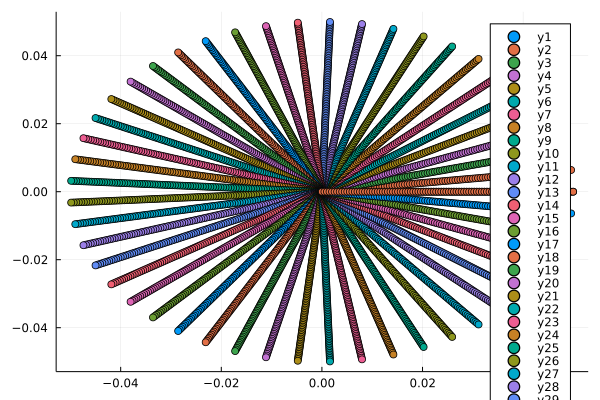

In [135]:
plot(x, y, seriestype = :scatter)

In [82]:
range(0,2,100)

LoadError: MethodError: no method matching range(::Int64, ::Int64, ::Int64)
[0mClosest candidates are:
[0m  range(::Any, ::Any; length, step) at range.jl:94
[0m  range(::Any; length, stop, step) at range.jl:91

In [95]:
grid=simplexgrid(0:100:2)

ExtendableGrid{Int64, Int32};
dim: 1 nodes: 1 cells: 0 bfaces: 2



In [117]:
grid=StepRangeLen(1,1//(10.0-1),10)

LoadError: MethodError: no method matching //(::Int64, ::Float64)
[0mClosest candidates are:
[0m  //(::Integer, [91m::Integer[39m) at rational.jl:62
[0m  //(::Integer, [91m::Rational[39m) at rational.jl:68
[0m  //([91m::Complex[39m, ::Real) at rational.jl:78
[0m  ...

In [116]:
for i in indices(grid)
    print(i,' ',grid[i],'\n')
end

1 1.0
2 1.1111111111111112
3 1.2222222222222223
4 1.3333333333333333
5 1.4444444444444444
6 1.5555555555555556
7 1.6666666666666665
8 1.7777777777777777
9 1.8888888888888888
10 2.0


In [42]:
@btime res=falses(10,1000)

  99.460 ns (2 allocations: 1.38 KiB)


10×1000 BitMatrix:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

In [37]:
eltype(res)

Bool

In [29]:
eltype(true)

Bool

In [47]:
for jj in indices(res,2)
    setindex!(res,true,1,jj)
end

In [53]:
sum(res[:,3])

2

In [368]:
function generate_rand_ra_dec(nrand)
    ra=rand(nrand)*360
    dec=rand(nrand)*180 .- 90
    return ra,dec
end
ra,dec=generate_rand_ra_dec(1000)
#convert to lb
#c1 = @. ICRSCoords(ra.*pi./180.0, dec.*pi./180) 
#c2 = @. convert(GalCoords, c1)

([170.45944195031868, 230.43481042106885, 118.0238874999473, 296.3121735285283, 12.133798777118837, 163.57206450914632, 136.99531340168667, 6.1311803600462955, 235.9407677038323, 75.01066725891468  …  309.68429460685184, 117.86100872614927, 30.891476506822855, 292.08405761879374, 139.5914780493638, 148.2047007378436, 129.32443156419947, 77.49517015319195, 28.99291701808607, 156.41524809234008], [-11.156462922185725, -63.830774290434064, -62.24060766929658, 24.990315952731166, 73.80035466720497, 71.7699812212621, -39.39467221176446, -12.961154654351787, -32.625165672122066, 65.01300571776298  …  -18.537538598282964, 17.709778727010246, -61.8071908097922, 83.82087523428487, 38.158784953793855, 52.638510991899125, -58.942947839033096, -80.70376487460624, 62.2870292685262, 5.234746241115431])

In [75]:
function assign_sky_zones(ra,dec,dRAzone,dDECzone)
    #assigns the zone for each object
    RA_ed=collect(0:dRAzone:360)
    DEC_ed=collect(-90:dDECzone:90)
    nRA=size(RA_ed,1)
    nDEC=size(DEC_ed,1)
    
    zone_num=zeros(Int32,size(ra,1))
    
    for ii in 1:nRA-1
        ibin=findall( (ra.> RA_ed[ii]) .& (ra.<=RA_ed[ii+1]))
        zone_num[ibin].=ii
    end
        
    for jj in 1:nDEC-1
        ibin=findall((dec.> DEC_ed[jj]) .& (dec.<=DEC_ed[jj+1]))
        zone_num[ibin].= zone_num[ibin] .+ (nRA*jj)
    end
        
    
    return zone_num
end

function assign_priority(nobj,priority,priority_frac)
    #= Generates uniform random numbers
    split from priority fraction
    assign priority
    =#
    
    @assert sum(priority_frac)==1
    
    obj_priority=zeros(Int32,nobj)
    rand_num=rand(nobj)
    #println(minimum(rand_num),' ',maximum(rand_num))
    n_class=size(priority,1)
    
    
    max_lim=0;
    #count_ass=zeros(Int32,nobj)
    for ii in 1:n_class
        min_lim=max_lim
        max_lim=min_lim+priority_frac[ii]
        ind_this=findall( (rand_num.>= min_lim) .& (rand_num.<=max_lim))
        obj_priority[ind_this] .= priority[ii]
        #count_ass[ind_this] .= count_ass[ind_this].+1
    end    
    return obj_priority
end

function sort_by_zone_priority(indsel,zone_num,obj_priority)
    #= first sort by zone and then sort by priority for each zone
    This construct a new variable to sort finally
     first sort by main variable, find minimum difference
    take second variable and set in the minimum difference
    add the scale second variable to first one and sort by this new quantity
    =#
    #sort by zone
    izone_sort=sortperm(zone_num)
    mindif=zone_num[izone_sort[2]]-zone_num[izone_sort[1]]
    
    #scale the second variable
    pr_min=minimum(obj_priority)
    pr_max=maximum(obj_priority)
    
    #new quantity for sorting
    new_q=(obj_priority .- pr_min)./(pr_max-pr_min)
    new_q=new_q+zone_num
    izone_sort=sortperm(new_q,rev=:true)
    return izone_sort
end

function approx_convert_ra_dec_to_gal_b(ra,dec)
   #=Convert ra,dec in degree to galactic latitude only b
    This is only approximate and can have error of about 0.01 degree
    =#
    deg2rad=pi/180
    alpha_NGP=192.85*deg2rad #ra in deg
    delta_NGP=27.14*deg2rad  #dec in deg
    l_NCP=6.28308866829052 # in radian
    
    sinb=sin(delta_NGP)*sin(dec*deg2rad)+ cos(delta_NGP)*cos(dec*deg2rad)*cos(ra*deg2rad-alpha_NGP)
    #cosb=sqrt(1-sinb*sinb)
    #cos_sin_lb= cos(dec)*sin(ra*deg2rad-alpha_NGP)
    
    #println(sinb,' ',cosb,' ',cos_sin_lb,' ',cos_sin_lb/cosb)
    
    #get l longitude and b latitude
    b=asin(sinb)/deg2rad
    #l=l_NCP-asin(cos_sin_lb/cosb)
    return b #in degree
end


function split_Galactic_cap(ra,dec,rettype)
    #return the indices of objects in NGC or SGC
    b= @. approx_convert_ra_dec_to_gal_b(ra,dec)
    
    if(rettype=="boolean")
        ind_NGC=b.>0
        ind_SGC=b.<=0
    else
        ind_NGC=findall(b.>0)
        ind_SGC=findall(b.<=0)
    end
    #ind_SGC=deleteat!([1:size(ra);], ind_NGC)
    
    
    return ind_NGC,ind_SGC
end


function pre_process_tracer(fname,priority,priority_frac,outfile)
    #= Pre-process a given tracer in following step
    priority is array containing list of priority
    priority_frac is simply the fraction for each priority should sum to 1
      1) read the fits file
      2) select y5 (2^1) foot-print and n(z) (2^0)
      3)  create zone ins ra-dec 20binx20bin
      3) split in NGC/SGC and next steps for each zone
        a) In each zone sort them according to priority (if multiple priority exists)
        b) Create a group and write each zone in seperate group
    =#
    
    fin=FITS(fname)
    println("Loading file: $(fname)")
    
    #apply footprint and nz selection
    status=read(fin[2],"STATUS")
    indsel=findall((status .& 2^1) .* (status .& 2^0).>1)
    #Only for testing to reduce size
    indsel=indsel[1:1000:size(indsel,1)]
    nobj=size(indsel,1)
    println("nobj selection (footprint and nz): $(nobj)")
    
    #read ra,dec of selection
    ra=keepat!(read(fin[2],"RA"),indsel)
    dec=keepat!(read(fin[2],"DEC"),indsel)
    
    println("Assigning zones and priority and sorting")
    #Assign zone number for each object
    zone_num=assign_sky_zones(ra,dec,20,20)
    #asign_priority
    obj_priority=assign_priority(nobj,priority,priority_frac)
    
    #sort by zone and then priority within zone in reverse order (higher priority first)
    indsel_pr_zone=indsel_pr_zone=sort_by_zone_priority(indsel,zone_num,obj_priority)  
    #for each priority further sorting can be done here if needed
    
    
    #re-ordering everything
    zone_num=zone_num[indsel_pr_zone]
    
    quant_dic=Dict()
    quant_dic["RA"]=ra[indsel_pr_zone]
    quant_dic["DEC"]=dec[indsel_pr_zone]
    quant_dic["PRIORITY"]=obj_priority[indsel_pr_zone]
    quant_dic["FITS_index"]=indsel[indsel_pr_zone]
    

    println("Writing to JLD2 file: $(outfile)")
    write_JLD2_file(outfile,zone_num,quant_dic)


    
    close(fin)
    
end

function write_JLD2_file(outfile,zone_num,quant_dic)
    #=Write the structured data in jld2 format with subgroup feature
     For any tracer write following structure
      -> NGC/SGC -> groupd in ra-dec zones
    =#
    us_zone=sort(unique(zone_num))
    #append!(size(zone_num,1),fel_zone)
    #@show(fel_zone,size(fel_zone),size(us_zone))
    
    quant_write=["RA","DEC","PRIORITY","FITS_index"]

    ind_NS=Dict()
    ind_NS["NGC"],ind_NS["SGC"]= split_Galactic_cap(quant_dic["RA"],quant_dic["DEC"],"boolean")
    
    groups_order=Dict()
    groups_order["NGC"]=Dict()
    groups_order["SGC"]=Dict()
    
    
    jldopen(outfile, "a+") do file
        for zz in 1:size(us_zone,1)
            zone=us_zone[zz]
            for sky in ["NGC","SGC"]
                isel=findall((zone_num .==zone) .&  (ind_NS[sky]))
                if(size(isel,1)==0)
                    continue
                end
                
                tgroup="$(sky)/zone_$(zone)"
                if(sky in keys(file))
                    if("zone_$(zone)" in keys(file[sky]))
                        gtmp=file[sky]["zone_$(zone)"]
                    else
                        gtmp=JLD2.Group(file, tgroup)
                    end
                else
                    gtmp=JLD2.Group(file, tgroup)
                end

                if(!("zone_order" in keys(groups_order[sky])) )
                        groups_order[sky]["zone_order"]=[]
                        groups_order[sky]["nobj"]=[]
                end
                
                append!(groups_order[sky]["zone_order"],["$(tgroup)/"])
                append!(groups_order[sky]["nobj"],size(isel,1))
                
                for quant in quant_write                               
                    gtmp["$(quant)"] = quant_dic[quant][isel] 
                end #ends the quant loop
            end#ends the sky loop
        end #ends the zone loop
        
        #Now write the zone order
        groups_order["NS"]=Dict()
        groups_order["NS"]["zone_order"]=[]
        groups_order["NS"]["nobj"]=[]
        groups_order["NS"]["beg_index"]=[]
        
        count_NS=1
        for sky in ["NGC","SGC"]
            groups_order[sky]["beg_index"]=[]
            count=1
            #println("$(sky) $(size(groups_order[sky]["zone_order"])) $(size(groups_order[sky]["nobj"])))")
            for tt in 1:size(groups_order[sky]["zone_order"],1)
                append!(groups_order[sky]["beg_index"],count)
                count=count+groups_order[sky]["nobj"][tt]
                
                #Also append for count_NS
                append!(groups_order["NS"]["zone_order"],[groups_order[sky]["zone_order"][tt]])
                append!(groups_order["NS"]["nobj"],groups_order[sky]["nobj"][tt])
                append!(groups_order["NS"]["beg_index"],count_NS)
                count_NS=count_NS+groups_order[sky]["nobj"][tt]
            end
            
            file[sky]["order"]=groups_order[sky]
        end
        file["order"]=groups_order["NS"]
            
    end #closes the JLD2 file
    
    
end


lrg_file="/Users/shadab/Documents/Projects/MockFBA/mocks/LRG/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits"
fname=lrg_file
priority=[3000,2000,1000]
priority_frac=[0.5,0.3,0.2]
outdir="/Users/shadab/Documents/Projects/MockFBA/mocks/JLD2_data/"
tracer="LRG_ph000"
#new_file=printfmt("{:s}{:s}.jld2",outdir,tracer)
outfile=@sprintf("%s%s.jld2",outdir,tracer)


pre_process_tracer(fname,priority,priority_frac,outfile)

println("Done")

Loading file: /Users/shadab/Documents/Projects/MockFBA/mocks/LRG/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
nobj selection (footprint and nz): 11978
Assigning zones and priority and sorting
Writing to JLD2 file: /Users/shadab/Documents/Projects/MockFBA/mocks/JLD2_data/LRG_ph000.jld2
Done


In [55]:
a1=[1,2,3]
a1_tmp=a1[[3,2,1]]
@show(a1,a1_tmp)

a1 = [1, 2, 3]
a1_tmp = [3, 2, 1]


3-element Vector{Int64}:
 3
 2
 1

In [71]:



    
tra=[0.0,10,20,30,40,100,110,120,130,140,345,360]
tdec=[-90,-80,-70,-60,-50,-30,0,10,20,30,40.0,50]

ra,dec=generate_rand_ra_dec(1000)
indsel=collect(1:size(ra,1))

zone_num=assign_sky_zones(ra[indsel],dec[indsel],20,20)
priority=[3000,2000,1000]
priority_frac=[0.5,0.3,0.2]
obj_priority=assign_priority(size(indsel,1),priority,priority_frac)
    
indsel_pr_zone=sort_by_zone_priority(indsel,zone_num,obj_priority)
#ind_NS=Dict()
#ind_NS["NGC"],ind_NS["SGC"]= split_Galactic_cap(ra[indsel_pr_zone],dec[indsel_pr_zone])

1000-element Vector{Int64}:
 937
 193
 696
 137
 251
 757
 849
  55
 239
 307
 537
 588
  83
   ⋮
 561
 789
 918
 958
 985
 995
 774
 979
 395
 484
 362
 671

1000-element Vector{Float64}:
  82.66148966513123
  84.10184816316072
  74.83842137479743
  77.44215405370869
  75.44172246922767
  86.12915715973975
  85.20764404386131
  74.03325727835846
  84.44341265914599
  86.71135781981565
  86.47900106854985
  71.78192680703592
  79.59874540764673
   ⋮
 -74.32054173449764
 -74.63117001355761
 -71.30493548768094
 -76.5228250043886
 -87.98653731787985
 -80.98529297726186
 -75.29539705491935
 -84.5683090098804
 -84.00360756685151
 -88.10697069076468
 -70.63537232166101
 -84.82776905057764

In [72]:
ind=findall(zone_num.==77)
@show(minimum(dec[ind]),maximum(dec[ind]))

@show(ra[ind],dec[ind])
plot(ra[ind],dec[ind],seriestype =:scatter)

minimum(dec[ind]) = -25.827600255257593
maximum(dec[ind]) = -11.892311749559738
ra[ind] = [8.365608004017297, 7.4741060647052615, 9.32936499409999, 16.602006149391766, 9.956939370959095]
dec[ind] = [-25.827600255257593, -18.336236036522806, -19.63439270619729, -11.892311749559738, -13.657877576194053]


In [73]:
zone_num=zone_num[indsel_pr_zone]
ra=ra[indsel_pr_zone]
dec=dec[indsel_pr_zone]
ind=findall(zone_num.==77)
@show(minimum(dec[ind]),maximum(dec[ind]))

@show(ra[ind],dec[ind])
plot(ra[ind],dec[ind],seriestype =:scatter)

minimum(dec[ind]) = -25.827600255257593
maximum(dec[ind]) = -11.892311749559738
ra[ind] = [7.4741060647052615, 9.32936499409999, 16.602006149391766, 8.365608004017297, 9.956939370959095]
dec[ind] = [-18.336236036522806, -19.63439270619729, -11.892311749559738, -25.827600255257593, -13.657877576194053]


In [370]:


outdir="/Users/shadab/Documents/Projects/MockFBA/mocks/JLD2_data/"
tracer="LRG"
#new_file=printfmt("{:s}{:s}.jld2",outdir,tracer)
outfile=@sprintf("%s%s.jld2",outdir,tracer)

#println(new_file)

fel_zone = Union{Nothing, Int64}[995, 982, 972, 965, 963, 959, 951, 943, 936, 933, 926, 920, 916, 911, 903, 899, 894, 886, 877, 868, 865, 857, 849, 840, 835, 826, 821, 812, 803, 797, 787, 785, 777, 771, 765, 762, 757, 753, 747, 743, 734, 729, 726, 719, 710, 707, 704, 699, 693, 687, 682, 676, 669, 665, 662, 652, 646, 635, 630, 628, 621, 610, 605, 599, 594, 589, 581, 572, 565, 559, 554, 552, 544, 540, 531, 525, 520, 512, 503, 495, 492, 486, 479, 471, 464, 461, 455, 451, 446, 443, 438, 428, 417, 416, 412, 408, 399, 390, 388, 382, 377, 374, 361, 356, 354, 348, 341, 334, 327, 320, 317, 309, 298, 296, 289, 287, 280, 273, 269, 261, 257, 250, 243, 236, 230, 226, 218, 215, 210, 207, 199, 194, 190, 185, 178, 174, 169, 163, 157, 152, 145, 135, 130, 122, 116, 109, 107, 98, 90, 86, 78, 71, 64, 58, 55, 48, 38, 29, 25, 20, 12, 1]
size(fel_zone) = (162,)
size(us_zone) = (162,)
SGC/zone_20 RA 19 982 1000
SGC/zone_21 RA 11 972 982
SGC/zone_22 RA 8 965 972
SGC/zone_23 RA 3 963 965
SGC/zone_24 RA 5 959 96

NGC/zone_167 DEC 11 135 145
NGC/zone_168 DEC 5 130 135
SGC/zone_168 DEC 1 130 135
NGC/zone_169 DEC 3 122 130
SGC/zone_169 DEC 6 122 130
NGC/zone_170 DEC 6 116 122
SGC/zone_170 DEC 1 116 122
NGC/zone_172 DEC 8 109 116
NGC/zone_173 DEC 3 107 109
NGC/zone_174 DEC 10 98 107
NGC/zone_175 DEC 9 90 98
NGC/zone_176 DEC 5 86 90
NGC/zone_177 DEC 9 78 86
NGC/zone_178 DEC 8 71 78
NGC/zone_179 DEC 8 64 71
NGC/zone_180 DEC 7 58 64
NGC/zone_181 DEC 4 55 58
NGC/zone_182 DEC 8 48 55
NGC/zone_183 DEC 11 38 48
NGC/zone_184 DEC 10 29 38
NGC/zone_185 DEC 5 25 29
NGC/zone_186 DEC 6 20 25
NGC/zone_187 DEC 9 12 20
NGC/zone_188 DEC 12 1 12
NGC/zone_189 DEC 1 1 1
SGC/zone_20 PRIORITY 19 982 1000
SGC/zone_21 PRIORITY 11 972 982
SGC/zone_22 PRIORITY 8 965 972
SGC/zone_23 PRIORITY 3 963 965
SGC/zone_24 PRIORITY 5 959 963
SGC/zone_25 PRIORITY 9 951 959
SGC/zone_26 PRIORITY 9 943 951
SGC/zone_27 PRIORITY 8 936 943
SGC/zone_28 PRIORITY 4 933 936
SGC/zone_29 PRIORITY 8 926 933
SGC/zone_30 PRIORITY 7 920 926
SGC/zone_3

SGC/zone_115 FITS_index 11 428 438
SGC/zone_116 FITS_index 12 417 428
SGC/zone_117 FITS_index 2 416 417
NGC/zone_118 FITS_index 2 412 416
SGC/zone_118 FITS_index 3 412 416
NGC/zone_119 FITS_index 4 408 412
SGC/zone_119 FITS_index 1 408 412
NGC/zone_120 FITS_index 10 399 408
NGC/zone_121 FITS_index 10 390 399
NGC/zone_122 FITS_index 3 388 390
NGC/zone_123 FITS_index 7 382 388
NGC/zone_124 FITS_index 6 377 382
NGC/zone_125 FITS_index 4 374 377
NGC/zone_126 FITS_index 14 361 374
NGC/zone_127 FITS_index 6 356 361
NGC/zone_128 FITS_index 2 354 356
SGC/zone_128 FITS_index 1 354 356
NGC/zone_129 FITS_index 1 348 354
SGC/zone_129 FITS_index 6 348 354
SGC/zone_130 FITS_index 8 341 348
SGC/zone_131 FITS_index 8 334 341
SGC/zone_132 FITS_index 8 327 334
SGC/zone_134 FITS_index 8 320 327
SGC/zone_135 FITS_index 4 317 320
NGC/zone_136 FITS_index 2 309 317
SGC/zone_136 FITS_index 7 309 317
NGC/zone_137 FITS_index 11 298 309
SGC/zone_137 FITS_index 1 298 309
NGC/zone_138 FITS_index 3 296 298
NGC/zone

Dict{Any, Any} with 3 entries:
  "beg_index"  => Any[1, 6, 7, 15, 22, 27, 28, 29, 37, 47  …  1126, 1127, 1131,…
  "nobj"       => Any[5, 1, 8, 7, 5, 1, 1, 8, 10, 4  …  1, 4, 6, 5, 8, 2, 2, 1,…
  "zone_order" => Any["NGC/zone_45", "NGC/zone_46", "NGC/zone_47", "NGC/zone_48…

In [384]:
function embed_sphere(ra, dec)
    #= Adapted from desimode.io """Embed `ra`, `dec` to a uniform sphere in three dimensions.
    Note that intentionallly x,y,z are kept at three arrays for efficiency as Julia uses column-major
    and three arrays will be easier to manipulate compared to one
    """
    =#

    deg2rad=pi/180.0

    phi = deg2rad.*ra
    theta = deg2rad.*(90.0 .- dec)
    r = @. sin(theta)
    x_unit =@.  r * cos(phi)
    y_unit =@.  r * sin(phi)
    z_unit =@. cos(theta)

    return x_unit,y_unit,z_unit
end


function embed_sphere!(ra,dec,x_unit,y_unit,z_unit)
    #= Adapted from desimode.io """Embed `ra`, `dec` to a uniform sphere in three dimensions.
    Note that intentionallly x,y,z are kept at three arrays for efficiency as Julia uses column-major
    and three arrays will be easier to manipulate compared to one
    This version uses pre-allocated arrrays to store data and hence modifies its argument
    """
    =#

    deg2rad=pi/180.0

    phi = deg2rad.*ra
    theta = deg2rad.*(90.0 .- dec)
    r = @. sin(theta)
    nobj=size(ra,1)
    @. x_unit = r * cos(phi)
    @. y_unit = r * sin(phi)
    @. z_unit = cos(theta)
end

function embed_sphere_xyzmatrix(ra,dec)
    #= calles embed sphere but returns a matrix which is sometimes convenient=#
    nra=size(ra,1)
    txyz=zeros(nra,3)
    embed_sphere!(ra, dec,view(txyz,1:nra,1),view(txyz,1:nra,2),view(txyz,:,3))
    
    return txyz
end

nra=size(ra,1)
tx,ty,tz=embed_sphere(ra, dec)
txyz=zeros(nra,3)
embed_sphere!(ra, dec,view(txyz,1:nra,1),view(txyz,1:nra,2),view(txyz,:,3))

txyz1=embed_sphere_xyzmatrix(ra,dec)

1000×3 Matrix{Float64}:
 -0.967532    0.162614    -0.193489
 -0.280913   -0.339985    -0.897495
 -0.218832    0.41115     -0.884911
  0.401763   -0.812471     0.422465
  0.272752    0.0586414    0.960295
 -0.300062    0.0884719    0.949808
 -0.565142    0.52709     -0.634659
  0.968948    0.104084    -0.22429
 -0.471683   -0.697741    -0.539141
  0.109252    0.40804      0.906404
 -0.785407   -0.448723    -0.42636
 -0.693997    0.412113     0.590366
  0.882022   -0.00965713   0.471109
  ⋮                       
  0.384869    0.495949    -0.778402
  0.591045   -0.762643    -0.262756
  0.605426   -0.729646    -0.317926
 -0.445181    0.842187     0.304196
  0.40542     0.242557    -0.881363
  0.040468   -0.0997402    0.99419
 -0.598723    0.509707     0.617843
 -0.515777    0.319736     0.794823
 -0.326926    0.399078    -0.856654
  0.0349767   0.157707    -0.986866
  0.406763    0.225407     0.885288
 -0.912647    0.398436     0.0912365

In [386]:
@show minimum(txyz-txyz1), maximum(txyz-txyz1)

(minimum(txyz - txyz1), maximum(txyz - txyz1)) = (0.0, 0.0)


(0.0, 0.0)

In [383]:
@show minimum(ty-txyz[:,2]),maximum(ty-txyz[:,2])

(minimum(ty - txyz[:, 2]), maximum(ty - txyz[:, 2])) = (0.0, 0.0)


(0.0, 0.0)

In [122]:
function embed_sphere(ra, dec)
    #= Adapted from desimode.io """Embed `ra`, `dec` to a uniform sphere in three dimensions.
    """
    =# 
    
    deg2rad=pi/180.0
    
    phi = deg2rad.*ra
    theta = deg2rad.*(90.0 .- dec)
    r = @. sin(theta)
    nobj=size(ra,1)
    xyz=zeros(Float64,(nobj,3))
 
    @. xyz[:,1] =  r * cos(phi)
    @. xyz[:,2] =  r * sin(phi)
    @. xyz[:,3] = cos(theta)
    
    return xyz
end


xyz=embed_sphere(ra, dec)

101×3 Matrix{Float64}:
 0.979771  0.0821356  -0.182492
 0.932412  0.184668   -0.310655
 0.942767  0.231828   -0.239677
 0.951553  0.213524   -0.221258
 0.926685  0.265192   -0.266324
 0.973787  0.0325374  -0.225125
 0.934422  0.254642   -0.249024
 0.920792  0.261378   -0.289523
 0.953072  0.218315   -0.209744
 0.928938  0.252477   -0.270796
 0.937168  0.214827   -0.274891
 0.977407  0.118068   -0.175313
 0.931759  0.26413    -0.249119
 ⋮                    
 0.979855  0.0676964  -0.187887
 0.938993  0.19097    -0.286047
 0.948997  0.180854   -0.258256
 0.924652  0.270965   -0.267575
 0.941005  0.265496   -0.209813
 0.976497  0.0782875  -0.20081
 0.967548  0.117495   -0.223708
 0.920505  0.286376   -0.26582
 0.932085  0.248313   -0.263737
 0.966103  0.156388   -0.205397
 0.942077  0.256661   -0.215906
 0.941119  0.17056    -0.291899

In [ ]:
rad=sqrt.(xyz[:,1].*xyz[:,1] .+ xyz[:,2].*xyz[:,2] .+ xyz[:,3].*xyz[:,3])
println(minimum(rad),' ',maximum(rad),' ',mean(rad))
for ii in indices(xyz,1)
    print(ii,"\n")
end

In [97]:
jldopen("example.jld2", "a+") do file
    g1 = JLD2.Group(file, "NGC/zone1")
    g2 = JLD2.Group(file, "NGC/zone2")
    g3 = JLD2.Group(file, "SGC/zone1")
    
    for g in [g1,g2,g3]
    #for g in ["NGC/zone1","NGC/zone2","SGC/zone1","NGC/zone4"]
        #save_object(file, "x",[1,2,3])
        g["DEC"]=[1,2,3]
        #file[g]["Y"]=[1,2,3]
    end
    td=Dict()
    td["DEC"]=[1,2]
    file["indexing"]=td
end

Dict{Any, Any} with 1 entry:
  "DEC" => [1, 2]

In [106]:
new_index=Dict()
jldopen("example.jld2", "r") do file
    
    new_index["DEC"]=[30,40]
    if("NGC/indexing" in keys(file))#load the file
        old_dic=file["indexing"]
        for tcol in keys(old_dic)
            if(tcol in keys(new_index))
                continue
            end
            new_index[tcol]=old_dic[tcol]
        end
    end
end


jldopen("example.jld2", "a+") do file
    Base.delete!(file,"indexing")
    write(file,"indexing",new_index)
end

In [113]:
jldopen("example.jld2", "a+") do file
    Base.delete!(file,"NGC/zone1/DEC")
    #write(file,"indexing",new_index)
end

In [114]:
file = jldopen("example.jld2", "r")

JLDFile /Users/shadab/Documents/Projects/MockFBA/example.jld2 (read-only)
 ├─📂 NGC
 │  ├─📂 zone1
 │  └─📂 zone2
 │     └─🔢 DEC
 ├─📂 SGC
 │  └─📂 zone1
 │     └─🔢 DEC
 └─🔢 indexing

In [109]:
file["indexing"]["DEC"]

2-element Vector{Int64}:
 30
 40

In [111]:
close(file)

In [352]:
function load_DESI_tiles(tile_file,program,pass,sky)
    #=load the tiles from a tile file and select for program and pass if given=#
    
    #open fits file
    fin=FITS(tile_file)
    println("Loading tiles from: $(tile_file)")
    
    nrow=size(read(fin[2],"RA"),1)
    
    tiles_dic=Dict()
    quant_need=["TILEID","RA","DEC","PASS"]
    
    sel_dic=Dict()
    if(program!=nothing)
        sel_dic["PROGRAM"]=program
    end
    if(pass!=nothing)
        sel_dic["PASS"]=pass
    end
    
    if(program==nothing && pass==nothing)
        indsel=1:nrow
    else
        indbool=trues(nrow)
        for tkey in keys(sel_dic)
            tval=read(fin[2],tkey)
            indbool .= indbool .& (tval .==sel_dic[tkey])
        end
        indsel=findall(indbool)
    end
    
    for qq in quant_need
        tiles_dic[qq]=keepat!(read(fin[2],qq),indsel)
    end
        
    #Now apply sky selection if needed
    if(sky!=nothing)
        ind_NS=Dict()
        ind_NS["NGC"],ind_NS["SGC"]=split_Galactic_cap(tiles_dic["RA"],tiles_dic["DEC"],"index")
        for qq in quant_need
            tiles_dic[qq]=tiles_dic[qq][ind_NS[sky]]
        end
    end
   
    close(fin)
    
    return tiles_dic
end

function deg2rad(rdeg)
    return pi*rdeg/180
end

function Assign_tile_id(tiles_dic,tile_radius_indeg,ra_tracer, dec_tracer)
    #= assign the object to the tile id, assumes tiles are non-overlapping=
    1) get xyz_unit for tile centers and ra, dec_tracer
    2) define the scales , assign zones, select tiles
    3) scan the object determine dot product and assign tiles 
    =#
    
    
    nobj=size(ra_tracer,1)
    ntile=size(tiles_dic["RA"],1)
    
    #min_RA=minimum(ra_tracer)-5.0*tile_radius_indeg
    #determine the radius in dot product unit
    radius_in_costheta=cos(deg2rad(tile_radius_indeg))
    #@show radius_in_costheta
    
    #determine the tiles centers in unit sphere
    tiles_xyz=embed_sphere(tiles_dic["RA"],tiles_dic["DEC"])
    
    #determine the tracers on unit sphere
    tracer_xyz=embed_sphere(ra_tracer,dec_tracer)
    
    
    count_assign=zeros(Int32,nobj)
    tileid_assign=zeros(Int32,nobj)
    
    #scan the two
    #rdist=zeros(Float64,nobj)
    for tt in 1:ntile
        rdist=costheta_uv(tiles_xyz[tt,:],tracer_xyz)
        indsel=findall(rdist .> radius_in_costheta)
        #@show(tiles_xyz[tt,:],size(indsel),nobj,minimum(rdist),maximum(rdist))
        if(size(indsel,1)==0)
            continue
        end
        tileid_assign[indsel] .= tiles_dic["TILEID"][tt]
        count_assign[indsel] .= count_assign[indsel] .+ 1
    end
    @assert maximum(count_assign)<=1
    return tileid_assign
end
    


ra_tracer=load_groupzone_column(jldfile,"SGC/zone_96/","RA")
dec_tracer=load_groupzone_column(jldfile,"SGC/zone_96/","DEC")

tile_file="footprint/Tiles_year1.fits"
program="DARK"
pass=0
sky="SGC"
tile_radius_indeg=1.65


tiles_dic=load_DESI_tiles(tile_file,program,pass,sky)
#tileid_assign=Assign_tile_id(tiles_dic,tile_radius_indeg,ra_tracer, dec_tracer)


@show unique(tileid_assign)


Loading tiles from: footprint/Tiles_year1.fits
unique(tileid_assign) = [0, 1154, 1145, 1175, 2045, 2053, 1155, 2065, 2042, 1147, 2047, 1146, 1188, 2048, 2051, 2062, 1546, 2052, 1176, 1165, 2061, 2049]


22-element Vector{Int64}:
    0
 1154
 1145
 1175
 2045
 2053
 1155
 2065
 2042
 1147
 2047
 1146
 1188
 2048
 2051
 2062
 1546
 2052
 1176
 1165
 2061
 2049

In [281]:
#zone=96
#ra_tracer=load_groupzone_column(jldfile,"SGC/zone_$(zone)/","RA")
#dec_tracer=load_groupzone_column(jldfile,"SGC/zone_$(zone)/","DEC")

plot(ra_tracer,dec_tracer,seriestype=:scatter,color=:black)
#plot!(tiles_dic["RA"],tiles_dic["DEC"],seriestype=:scatter,color=:yellow)

utile=unique(tileid_assign)
tt=22
indsel=findall(tileid_assign .== utile[tt])

plot!(ra_tracer[indsel],dec_tracer[indsel],seriestype=:scatter,color=:red)

ind_tile=findall(tiles_dic["TILEID"] .== utile[tt])
scatter!([tiles_dic["RA"][ind_tile]],[tiles_dic["DEC"][ind_tile]], color = "green", label = "", markersize = 10)

In [295]:
count_new=zeros(size(count_ass[0],1))
for pass in keys(count_ass)
    count_new .= count_new .+ count_ass[pass]
end

indsel=findall(count_new .>= 7)
plot(ra_tracer,dec_tracer,seriestype=:scatter,color=:black)
plot!(ra_tracer[indsel],dec_tracer[indsel],seriestype=:scatter,color=:red)
#@show minimum(count_new),maximum(count_new)

In [360]:
function traverse_group(jldfile,group)
    #= Traverse a JLD2 group for all the file within by loading order
    =#
    #jldopen("mocks/JLD2_data/LRG.jld2", "r") do file
    #    tgroup=file["$(group)/order"]
    #end
    
    return load(jldfile,"$(group)/order")
end

function check_variable_exists(jldfile,var_path)
    #= checks if a given variable path exists in the file=#
    var_arr=split(var_path,"/")
    file=jldopen(jldfile,"r")
    res=true
    tfile=file
    for tcol in var_arr
        if(!(tcol in keys(tfile)))
            res=false
            break
        end
        tfile=tfile[tcol]
    end
        
    close(file)
    return res
end

function load_groupzone_column(jldfile,group_zone,column)
    #=loads a column for a particular group and zone
    column should be a single column name=#
    
    this_col=load(jldfile,"$(group_zone)/$(column)")
    
    return this_col
end

function Append_groupzone_xyz_unit(jldfile,group_zone)
    #=Add xyz in unit sphere for a particular group and zone
    First check for if the column name exists=#
    col_name="XYZ_UNIT"
    
    if(check_variable_exists(jldfile,"$(group_zone)$(col_name)"))
        println("exists: $(group_zone)$(col_name)")
        return
    end
    
    #loads the ra,dec
    ra=load_groupzone_column(jldfile,group_zone,"RA")
    dec=load_groupzone_column(jldfile,group_zone,"DEC")
    #ra,dec=load(jldfile,"$(group)/RA","$(group)/DEC")
    
    #embeds the sphere
    unit_xyz=embed_sphere(ra, dec)
    
    #Now write this to the file
    jldopen(jldfile, "a+") do file
        write(file,"$(group_zone)/$(col_name)",unit_xyz)
    end
end


function Append_groupzone_TILEID(jldfile,group_zone)
    #=Add xyz in unit sphere for a particular group and zone
    First check for if the column name exists=#
    col_name="XYZ_UNIT"
    
    if(check_variable_exists(jldfile,"$(group_zone)$(col_name)"))
        println("exists: $(group_zone)$(col_name)")
        return
    end
    
    #loads the ra,dec
    ra=load_groupzone_column(jldfile,group_zone,"RA")
    dec=load_groupzone_column(jldfile,group_zone,"DEC")
    #ra,dec=load(jldfile,"$(group)/RA","$(group)/DEC")
    
    #embeds the sphere
    unit_xyz=embed_sphere(ra, dec)
    
    #Now write this to the file
    jldopen(jldfile, "a+") do file
        write(file,"$(group_zone)/$(col_name)",unit_xyz)
    end
end

function load_group_column(jldfile,group,columns)
    #=loads a column for a particular group scanning all the zones
    columns should be Array of available properties=#
    
    
    #load the zones in group
    jld_order=traverse_group(jldfile,group)
    
    #initialize the ditionary
    col_dic=Dict()
    for col in columns
        col_dic[col]=[]
    end
    
    for iz in 1:size(jld_order["zone_order"],1)
        tg=jld_order["zone_order"][iz]
        
        
        for col in columns
            append!(col_dic[col],load_groupzone_column(jldfile,tg,col))
        end
            
    end
    return col_dic
end


function Indexing_column(jldfile,group,columns,mask)
    #=Generate index file for groups
    writes a ditionary for each minimum and maximum values=#
    
    #load the zones in group
    jld_order=traverse_group(jldfile,group)
    
    #initialize the ditionary
    minmax_dic=Dict()
    for col in columns
        minmax_dic[col]=zeros(size(jld_order["zone_order"],1),2)
    end
    
    for iz in 1:size(jld_order["zone_order"],1)
        tg=jld_order["zone_order"][iz]
        
        for col in columns
            this_col=load_groupzone_column(jldfile,tg,col)
            if(mask!=nothing)
                ind_sub=falses(size(this_col,1))
                for mm in mask
                    ind_sub .= ind_sub .|| (this_col .== mm)
                end
                indsel=findall(@. !ind_sub)
                keepat!(this_col,indsel)
            end
            if(size(this_col,1)==0)#This will happen only when mask is available
                minmax_dic[col][iz,:]=[mask[1],mask[1]]
            else
                minmax_dic[col][iz,:]=[minimum(this_col),maximum(this_col)]
            end
        end    
    end
    
    #Now check if indexing exists
    update_dictionary_jld2file(jldfile,group,minmax_dic,"indexing")
    
    
    return minmax_dic
    
end

function LISTING_column(jldfile,group,outname,columns_use)
    #=For each zone generate the unique list of values in a particular colums
    This should be only used for columns which has small number of unique values
    for example TILEID=#
    
    #load the zones in group
    jld_order=traverse_group(jldfile,group)
    
    #initialize the ditionary
    unique_dic=Dict()
    unique_dic[outname]=Dict()
    #for col in columns
    #    minmax_dic[col]=zeros(size(jld_order["zone_order"],1),2)
    #end
    
    for iz in 1:size(jld_order["zone_order"],1)
        tg=jld_order["zone_order"][iz]
        
        comb_col=[]
        for col in columns_use
            this_col=load_groupzone_column(jldfile,tg,col)
            append!(comb_col,unique(this_col))
        end
        unique_dic[outname][iz]=unique(comb_col)
    end
    
    #Now check if indexing exists
    update_dictionary_jld2file(jldfile,group,unique_dic,"listing")
    
    
    return unique_dic
    
end



function update_dictionary_jld2file(jldfile,group,new_index,key)
    #= check if dictionary exists then load and merge with new dictionary and write the new one
    first delete the old one before writing=#
    
    dic_exists=check_variable_exists(jldfile,"$(group)/$(key)")
    old_dic=Dict()
    
    if( dic_exists)
        old_dic=load(jldfile,"$(group)/$(key)")
    end
    
    
    #Include old indexing if not updated in new_index     
    for tcol in keys(old_dic)
        if(tcol in keys(new_index))
            continue
        end
        new_index[tcol]=old_dic[tcol]
    end 
   
    jldopen(jldfile, "a+") do file
        #delete if needed or just write
        if(dic_exists)
            Base.delete!(file,"$(group)/$(key)")
        end
        write(file,"$(group)/$(key)",new_index)
    end
end

function Append_column(jldfile,group,columns)
    #=Add the given propety if doesn't already exists
    A reference group needs to be given which can empty string or NGC/SGC=#
    
    #load the zones in group
    jld_order=traverse_group(jldfile,group)
    
    for iz in 1:size(jld_order["zone_order"],1)
        tg=jld_order["zone_order"][iz]
        
        for col in columns
            if(col=="XYZ_UNIT")
                Append_groupzone_xyz_unit(jldfile,tg)
            else
                println("Not Implemented Append for $(col)")
            end
        end    
    end
end


function Append_TileID(tile_file,group,program,npass,tile_radius_indeg,overwrite)
    #= Assign tile id for each pass to a given tracer
    =#
    
    if("SGC" in split(group,"/"))
        sky="SGC"
    elseif("NGC" in split(group,"/"))
        sky="NGC"
    else
        sky=nothing
    end
       
    
    #load tiles for all the passes
    tiles_dic=Dict()
    for pass in 0:npass-1
        tiles_dic[pass]=load_DESI_tiles(tile_file,program,pass,sky)
    end
            
    
    #load the zones in group
    jld_order=traverse_group(jldfile,group)
    
    for iz in 1:size(jld_order["zone_order"],1)
        tg=jld_order["zone_order"][iz]
        
        ra_tracer=load_groupzone_column(jldfile,tg,"RA")
        dec_tracer=load_groupzone_column(jldfile,tg,"DEC")
        
        for pass in 0:npass-1
            tile_pass_exists=check_variable_exists(jldfile,"$(tg)TILEID_PASS$(pass)")
            
            if(tile_pass_exists & !overwrite)
                println("$(tg)/TILEID_PASS$(pass) exists with no-overwrite")
                continue
            end
            #@show pass,tg,tile_pass_exists & !overwrite, tile_pass_exists
            
            tileid_assign=Assign_tile_id(tiles_dic[pass],tile_radius_indeg,ra_tracer, dec_tracer)
            jldopen(jldfile, "a+") do file
                #delete if needed or just write
                if(tile_pass_exists)
                    Base.delete!(file,"$(tg)TILEID_PASS$(pass)")
                end
                write(file,"$(tg)TILEID_PASS$(pass)",tileid_assign)
            end
        end    
    end
end



function Load_tile(jldfile,tile_id,tile_pass,group,columns)
    #= load all objects in a particular tile
    also returns indices with reference to the group which can be used to load 
    or write back additional properties later
    =#
    
    #load the zones in group
    jld_order=traverse_group(jldfile,group)
    
    #load the listing to identify the zones which has tile
    listing=load(jldfile,"$(group)/listing")
    
    
    indsel=[] 
    #Dictionary to store the tracer properties
    tracer_tile=Dict()
    tracer_tile["ref_group"]=group
    tracer_tile["TILEID"]=tile_id
    tracer_tile["PASS"]=tile_pass
    tracer_tile["index"]=[]
    for col in columns
        tracer_tile[col]=[]
    end
    
    for iz in 1:size(jld_order["zone_order"],1)
        tg=jld_order["zone_order"][iz]
        
        #if tileid not in listing then continue
        if( !(tile_id in listing["TILEID"][iz]))
            continue
        end
        
        #Now load the tile_id is in this zone
        
        this_id_arr=load(jldfile,"$(tg)TILEID_PASS$(tile_pass)")
        #It is important to make sure the reference groups are used consistently for indices to work
        indsel_this=findall(this_id_arr .== tile_id) 
        
        append!(tracer_tile["index"], indsel_this.+ jld_order["beg_index"][iz] )
        
        for col in columns
            tcol_val=keepat!(load(jldfile,"$(tg)$(col)"),indsel_this)
            append!(tracer_tile[col],tcol_val)
        end
    end
    return tracer_tile
    
end
    
    
jldfile="/Users/shadab/Documents/Projects/MockFBA/mocks/JLD2_data/LRG_ph000.jld2"
group="SGC"
#traverse_group(jldfile,group)
#tra=load_groupzone_column(jldfile,"SGC/zone_77/","XYZ_UNIT")

#res1=load_group_column(jldfile,group,["RA"])
#Indexing_column(jldfile,group,["RA","DEC"],nothing)

#Append_groupzone_xyz_unit(jldfile,"SGC/zone_77/")
#Append_column(jldfile,group,["XYZ_UNIT"])

tile_file="footprint/Tiles_year1.fits"
program="DARK"
npass=7
tile_radius_indeg=1.65
overwrite=false

#Append_TileID(tile_file,group,program,npass,tile_radius_indeg,overwrite)

#Indexing_column(jldfile,group,["TILEID_PASS0"],[0])

#udic=LISTING_column(jldfile,group,"TILEID",["TILEID_PASS0","TILEID_PASS1","TILEID_PASS2","TILEID_PASS3",
        #"TILEID_PASS4","TILEID_PASS5","TILEID_PASS6"])

tt=1
tile_id=tiles_dic["TILEID"][tt]
tile_pass=0

tracer_tile=Load_tile(jldfile,tile_id,tile_pass,group,["RA","DEC","TILEID_PASS0"])

println("Done")

Done


In [366]:
tracer_tile["TILEID_PASS0"]
#@show tile_id
plot(tracer_tile["RA"],tracer_tile["DEC"],seriestype=:scatter)
tt=1
plot!([tiles_dic["RA"][tt]],[tiles_dic["DEC"][tt]],seriestype=:scatter,color = "green", label = "", markersize = 10)



In [367]:
tracer_tile

Dict{Any, Any} with 7 entries:
  "ref_group"    => "SGC"
  "PASS"         => 0
  "RA"           => Any[22.3594, 20.8949, 21.0462, 20.856, 21.512, 20.4757, 20.…
  "TILEID"       => 1006
  "TILEID_PASS0" => Any[1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006]
  "index"        => Any[1009, 1124, 1127, 1144, 1165, 1233, 1248, 1259, 1284]
  "DEC"          => Any[0.000823975, -0.730064, 1.574, -0.143539, 1.16489, -0.5…

In [351]:
close(file)

In [331]:
check_variable_exists(jldfile,"SGC/listing")

true

In [144]:


jldfile="/Users/shadab/Documents/Projects/MockFBA/mocks/JLD2_data/LRG_ph000.jld2"
var_path="NGC/zone_85/XYZ_UNIT"
#check_variable_exists(jldfile,var_path)

for tk in tkeys
    println(tk,' ',check_variable_exists(jldfile,"NGC/$(tk)/XYZ_UNIT"))
end

order false
zone_84 true
zone_85 true
zone_86 true
zone_101 true
zone_102 true
zone_103 true
zone_104 true
zone_105 true
zone_106 true
zone_107 true
zone_108 true
zone_109 true
zone_120 true
zone_121 true
zone_122 true
zone_123 true
zone_124 true
zone_125 true
zone_126 true
zone_127 true
zone_128 true
zone_139 true
zone_140 true
zone_141 true
zone_142 true
zone_143 true
zone_144 true
zone_145 true
zone_146 true
zone_147 true
zone_148 true
zone_157 true
zone_158 true
zone_159 true
zone_160 true
zone_161 true
zone_162 true
zone_163 true
zone_164 true
zone_165 true
zone_166 true
zone_167 true
zone_176 true
zone_177 true
zone_178 true
zone_179 true
zone_180 true
zone_181 true
zone_182 true
zone_183 true
zone_184 true
zone_185 true
zone_186 true
indexing false


Error encountered while load FileIO.File{FileIO.DataFormat{:JLD2}, String}("/Users/shadab/Documents/Projects/MockFBA/mocks/JLD2_data/LRG_ph000.jld2").

Fatal error:


LoadError: KeyError: key "RA" not found
Stacktrace:
  [1] [0m[1mgetindex[22m[0m[1m([22m[90mg[39m::[0mJLD2.Group[90m{JLD2.JLDFile{JLD2.MmapIO}}[39m, [90mname[39m::[0mString[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mgroups.jl:100[24m[39m
  [2] [0m[1mread[22m[0m[1m([22m[90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90mname[39m::[0mString[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mJLD2.jl:375[24m[39m
  [3] [0m[1mjlread[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mJLD2.jl:40[24m[39m[90m [inlined][39m
  [4] [0m[1m#78[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mfileio.jl:55[24m[39m[90m [inlined][39m
  [5] [0m[1mmap[22m
[90m    @ [39m[90m./[39m[90m[4mtuple.jl:222[24m[39m[90m [inlined][39m
  [6] [0m[1m#77[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mfileio.jl:55[24m[39m[90m [inlined][39m
  [7] [0m[1mjldopen[22m[0m[1m([22m::[0mJLD2.var"#77#79"[90m{Tuple{String, String}}[39m, ::[0mString, ::[0mVararg[90m{String}[39m; [90mkws[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mloadsave.jl:4[24m[39m
  [8] [0m[1mjldopen[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mloadsave.jl:2[24m[39m[90m [inlined][39m
  [9] [0m[1m#fileio_load#76[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mfileio.jl:54[24m[39m[90m [inlined][39m
 [10] [0m[1mfileio_load[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mfileio.jl:54[24m[39m[90m [inlined][39m
 [11] [0m[1m#fileio_load#75[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mfileio.jl:50[24m[39m[90m [inlined][39m
 [12] [0m[1mfileio_load[22m[0m[1m([22m::[0mFileIO.File[90m{FileIO.DataFormat{:JLD2}, String}[39m, ::[0mString, ::[0mString[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/AilrO/src/[39m[90m[4mfileio.jl:50[24m[39m
 [13] [0m[1minvokelatest[22m[0m[1m([22m::[0mAny, ::[0mAny, ::[0mVararg[90m{Any}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m./[39m[90m[4messentials.jl:716[24m[39m
 [14] [0m[1minvokelatest[22m[0m[1m([22m::[0mAny, ::[0mAny, ::[0mVararg[90m{Any}[39m[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m./[39m[90m[4messentials.jl:714[24m[39m
 [15] [0m[1maction[22m[0m[1m([22m::[0mSymbol, ::[0mVector[90m{Union{Base.PkgId, Module}}[39m, ::[0mFileIO.Formatted, ::[0mString, ::[0mVararg[90m{String}[39m; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[36mFileIO[39m [90m~/.julia/packages/FileIO/FUXWu/src/[39m[90m[4mloadsave.jl:219[24m[39m
 [16] [0m[1maction[22m[0m[1m([22m::[0mSymbol, ::[0mVector[90m{Union{Base.PkgId, Module}}[39m, ::[0mFileIO.Formatted, ::[0mString, ::[0mString[0m[1m)[22m
[90m    @ [39m[36mFileIO[39m [90m~/.julia/packages/FileIO/FUXWu/src/[39m[90m[4mloadsave.jl:197[24m[39m
 [17] [0m[1maction[22m[0m[1m([22m::[0mSymbol, ::[0mVector[90m{Union{Base.PkgId, Module}}[39m, ::[0mSymbol, ::[0mString, ::[0mString, ::[0mVararg[90m{String}[39m; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[36mFileIO[39m [90m~/.julia/packages/FileIO/FUXWu/src/[39m[90m[4mloadsave.jl:185[24m[39m
 [18] [0m[1maction[22m[0m[1m([22m::[0mSymbol, ::[0mVector[90m{Union{Base.PkgId, Module}}[39m, ::[0mSymbol, ::[0mString, ::[0mString, ::[0mVararg[90m{String}[39m[0m[1m)[22m
[90m    @ [39m[36mFileIO[39m [90m~/.julia/packages/FileIO/FUXWu/src/[39m[90m[4mloadsave.jl:185[24m[39m
 [19] [0m[1mload[22m[0m[1m([22m::[0mString, ::[0mString, ::[0mVararg[90m{String}[39m; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[36mFileIO[39m [90m~/.julia/packages/FileIO/FUXWu/src/[39m[90m[4mloadsave.jl:113[24m[39m
 [20] [0m[1mload[22m
[90m    @ [39m[90m~/.julia/packages/FileIO/FUXWu/src/[39m[90m[4mloadsave.jl:110[24m[39m[90m [inlined][39m
 [21] [0m[1mAppend_groupzone_xyz_unit[22m[0m[1m([22m[90mjldfile[39m::[0mString, [90mgroup_zone[39m::[0mString[0m[1m)[22m
[90m    @ [39m[32mMain[39m [90m./[39m[90m[4mIn[116]:31[24m[39m
 [22] top-level scope
[90m    @ [39m[90m[4mIn[118]:1[24m[39m

In [349]:

file = jldopen("/Users/shadab/Documents/Projects/MockFBA/mocks/JLD2_data/LRG_ph000.jld2", "r")


JLDFile /Users/shadab/Documents/Projects/MockFBA/mocks/JLD2_data/LRG_ph000.jld2 (read-only)
 ├─🔢 order
 ├─📂 SGC
 │  ├─🔢 order
 │  ├─📂 zone_77
 │  │  ├─🔢 RA
 │  │  ├─🔢 DEC
 │  │  ├─🔢 PRIORITY
 │  │  └─ ⋯ (9 more entries)
 │  └─ ⋯ (25 more entries)
 └─ ⋯ (4 more entries)

In [350]:
keys(file["NGC"]["listing"])
tind=file["listing"]
for ii in keys(tind["TILEID"])
    println(ii,' ',tind["TILEID"][ii],'\n')
end

5 Any[0, 2567, 2564, 2369, 2531, 2569, 2379, 2545, 2539, 2529, 3936, 4102, 3937, 3946, 4103, 4092, 4125, 4089, 3982, 3135, 4093, 4101, 3939, 3950, 5654, 5687, 5502, 5684, 5500, 5652, 5546, 5653, 5660, 5542, 5650, 5514, 4700, 7216, 7068, 7067, 7065, 7251, 7255, 7218, 6261, 7226, 7225, 7252, 7217, 7111, 8801, 8820, 8680, 8636, 8644, 8789, 8634, 8788, 8648, 8637, 8791, 10355, 10190, 10188, 10369, 10191, 10366, 9392, 10200, 10354, 10357, 10193, 11927, 11937, 11926, 11761, 11763, 10965, 11760, 11952, 10974, 11925, 11924, 11773, 11928]

56 Any[0]

35 Any[0, 2329, 2338, 2298, 1374, 3892, 5467, 5470, 7031, 8579]

55 Any[0]

16 Any[0, 1463, 1468]

20 Any[0, 1392, 1389, 1398, 1429, 1391, 1393, 1416, 1220, 2961, 2974, 2966, 2964, 2795, 2973, 4539, 4350, 4549, 4547, 4560, 4540, 6100, 6104, 6113, 6105, 6114, 6103, 6098, 6128, 6112, 6126, 7657, 7671, 7669, 7661, 7662, 7680, 7477, 9203, 9229, 9208, 9205, 9064, 9206, 9210, 9215, 10773, 10590, 10786, 10771, 10778, 10783, 10784, 10776, 10777]

60 Any[0]

33 Any[0, 1952, 5440, 5083, 7012, 8769, 11538]

71 Any[0, 2648, 9647]

66 Any[0, 1821, 1855, 1865, 1824, 1853, 1878, 1864, 1856, 1537, 1862, 1822, 1818, 2288, 1825, 1823, 1010, 3421, 3380, 3387, 3414, 3413, 3381, 3422, 3436, 3427, 3374, 3415, 3399, 3379, 3420, 3402, 3386, 3110, 3419, 4984, 4943, 4944, 4949, 4948, 4950, 4982, 4989, 4956, 4992, 4971, 4988, 4959, 4983, 4996, 4955, 4946, 4968, 4947, 6567, 6525, 6528, 6558, 6526, 6522, 6570, 6527, 6581, 6521, 6561, 6524, 6560, 6569, 6533, 8075, 8068, 8101, 8069, 8107, 8090, 8102, 8103, 8115, 8109, 8110, 8088, 8074, 8067, 8087, 8078, 8108, 9661, 9656, 9636, 9651, 9652, 9664, 9657, 9617, 9658, 9353, 9623, 9640, 9637, 9639, 9674, 9616, 9624, 9675, 9655, 9364, 11195, 11232, 11208, 11219, 11220, 11224, 11222, 11229, 11225, 11223, 11204, 11207, 11185, 11205, 11244, 11226]

76 Any[0, 4446]

40 Any[0]

48 Any[0]

34 Any[0, 2338, 3526, 3523, 3867, 5471, 5057, 5083, 5433, 5470, 7012, 8575, 9746]

50 Any[0]

59 Any[0]

15 Any[0, 2408, 1342, 2403, 3056

In [108]:
IJulia.clear_output(true)
#Plots.plotlyjs()


    
tind=file["SGC/indexing"]
for ii in 1:size(tind["RA"],1)
    xx=[tind["RA"][ii,1],tind["RA"][ii,2],tind["RA"][ii,2],tind["RA"][ii,1],tind["RA"][ii,1]]
    yy=[tind["DEC"][ii,1],tind["DEC"][ii,1],tind["DEC"][ii,2],tind["DEC"][ii,2],tind["DEC"][ii,1]]
    println(tind["RA"][ii,:],tind["DEC"][ii,:])
    if(ii==1)
        plot(xx,yy)
    else
        plot!(xx,yy)
    end
    
end
plot!(xx,yy) #|> display
#display(plot)
#display(MIME"image/png", plot)

[0.1426374316215515, 19.816238403320312][-19.56561279296875, -10.092216491699219]
[20.004398345947266, 39.831764221191406][-19.981857299804688, -10.065032958984375]
[40.155845642089844, 59.740379333496094][-20.22209930419922, -10.078948974609375]
[60.00244140625, 71.95205688476562][-20.1151123046875, -10.008567810058594]
[310.10821533203125, 319.99810791015625][-13.866378784179688, -10.181686401367188]
[320.12957763671875, 339.1470031738281][-15.229850769042969, -10.136215209960938]
[340.2348327636719, 359.5310363769531][-15.568016052246094, -10.132438659667969]
[0.16279840469360352, 19.87162208557129][-9.959526062011719, 9.992218017578125]
[20.02321434020996, 39.87953567504883][-9.888031005859375, 9.974494934082031]
[40.084320068359375, 59.6806526184082][-9.906822204589844, 9.53424072265625]
[60.20716094970703, 76.09818267822266][-9.957130432128906, 2.0224685668945312]
[308.3006286621094, 319.9794616699219][-9.824005126953125, 9.8240966796875]
[320.2371520996094, 339.84747314453125][-

In [376]:
t1=file["order"]#["zone_1"]["RA"])
tN=file["NGC"]["order"]
tS=file["SGC"]["order"]

Dict{Any, Any} with 3 entries:
  "beg_index"  => Any[1, 20, 31, 39, 42, 47, 56, 65, 73, 77  …  536, 537, 541, …
  "nobj"       => Any[19, 11, 8, 3, 5, 9, 9, 8, 4, 8  …  1, 4, 6, 5, 8, 2, 2, 1…
  "zone_order" => Any["SGC/zone_20", "SGC/zone_21", "SGC/zone_22", "SGC/zone_23…

In [321]:
close(file)

In [385]:
tt=t1
@show(size(tt["nobj"],1))
for ii in 1:size(tt["nobj"],1)
    print("$(tt["zone_order"][ii]), $(tt["nobj"][ii]) $(tt["beg_index"][ii])\n")
end

size(tt["nobj"], 1) = 193
NGC/zone_45, 5 1
NGC/zone_46, 1 6
NGC/zone_47, 8 7
NGC/zone_48, 7 15
NGC/zone_49, 5 22
NGC/zone_50, 1 27
NGC/zone_63, 1 28
NGC/zone_64, 8 29
NGC/zone_65, 10 37
NGC/zone_66, 4 47
NGC/zone_67, 4 51
NGC/zone_68, 6 55
NGC/zone_69, 5 61
NGC/zone_70, 2 66
NGC/zone_71, 1 68
NGC/zone_81, 1 69
NGC/zone_82, 8 70
NGC/zone_83, 12 78
NGC/zone_84, 6 90
NGC/zone_85, 7 96
NGC/zone_86, 6 103
NGC/zone_87, 6 109
NGC/zone_88, 9 115
NGC/zone_89, 4 124
NGC/zone_99, 1 128
NGC/zone_100, 6 129
NGC/zone_101, 10 135
NGC/zone_102, 9 145
NGC/zone_103, 4 154
NGC/zone_104, 7 158
NGC/zone_105, 8 165
NGC/zone_106, 9 173
NGC/zone_107, 8 182
NGC/zone_108, 4 190
NGC/zone_109, 3 194
NGC/zone_110, 1 197
NGC/zone_118, 2 198
NGC/zone_119, 4 200
NGC/zone_120, 10 204
NGC/zone_121, 10 214
NGC/zone_122, 3 224
NGC/zone_123, 7 227
NGC/zone_124, 6 234
NGC/zone_125, 4 240
NGC/zone_126, 14 244
NGC/zone_127, 6 258
NGC/zone_128, 2 264
NGC/zone_129, 1 266
NGC/zone_136, 2 267
NGC/zone_137, 11 269
NGC/zone_138, 3

In [302]:
keytype(file["NGC"]["zone1"]["RA"])

Int64

In [164]:
ra_new=ra[indsel[indsel_pr_zone]]
dec_new=dec[indsel[indsel_pr_zone]]
zone_new=zone_num[indsel_pr_zone]
obj_pr_new=obj_priority[indsel_pr_zone]

458-element Vector{Int32}:
 3000
 3000
 3000
 3000
 2000
 2000
 2000
 1000
 3000
 3000
 3000
 3000
 3000
    ⋮
 3000
 3000
 2000
 1000
 3000
 2000
 2000
 3000
 1000
 2000
 3000
 2000

In [105]:
@show minimum(tp)
@show size(findall(tp.==0))


minimum(tp) = 1000
size(findall(tp .== 0)) = (0,)


(0,)

In [192]:
n="tt"
m=2
"x$(n)$(m)"

"xtt2"

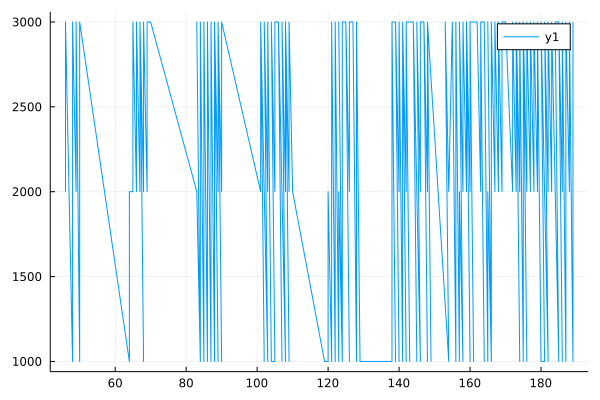

In [168]:
plot(zone_new,obj_pr_new)#,seriestype = :scatter)

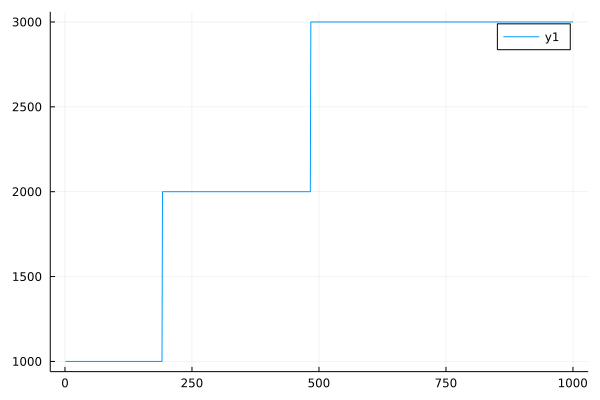

In [112]:
plot(tp[sortperm(tp)])

In [62]:

@btime zone_num=assign_sky_zones(ra,dec,20,20)


  2.578 ms (157 allocations: 2.73 MiB)


100000-element Vector{Int32}:
 174
 150
  46
 158
 157
 121
  55
 189
  92
  98
 142
 168
  72
   ⋮
 107
  37
 126
 123
 139
  99
  98
 111
 106
  75
 107
  52

In [ ]:
#IJulia.clear_output(true)
#plot(tra,tdec,seriestype = :scatter,color=:black)

for zz in unique(zone_num)
    iz=findall(zone_num.==zz)
    #@show(zz,minimum(ra[iz])-maximum(ra[iz]),maximum(dec[iz])-minimum(dec[iz]))
    #plot!(ra[iz],dec[iz],seriestype = :scatter) #|>  display
end

plot!([180],[0]) |> display



In [ ]:
#@btime deleteat!([1:size(ra,1);], ind_NGC)
@btime ind_SGC=findall(b.<=0)

In [142]:
b_off=similar(b)
for ii in indices(b)
    b_off[ii]=c2[ii].b*180/pi
end

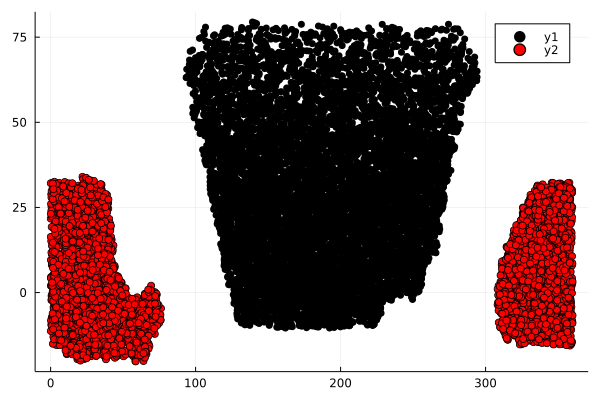

In [93]:
plot(ra[ind_NGC],dec[ind_NGC],seriestype = :scatter,color = :black)
plot!(ra[ind_SGC],dec[ind_SGC],seriestype = :scatter,color = :red)

In [11]:
lrg_file="/Users/shadab/Documents/Projects/MockFBA/mocks/LRG/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits"

"/Users/shadab/Documents/Projects/MockFBA/mocks/LRG/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits"

In [20]:
fin=FITS(lrg_file)

File: /Users/shadab/Documents/Projects/MockFBA/mocks/LRG/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
Mode: "r" (read-only)
HDUs: Num  Name  Type   
      1          Image  
      2          Table  

In [63]:
#status=read(fin[2],"STATUS")
ra=keepat!(read(fin[2],"RA"),indsel_sub)
dec=keepat!(read(fin[2],"DEC"),indsel_sub)
#dec=read(fin[2], "DEC")
    
#println(fin[2])
#close(fin)

11978-element Vector{Float32}:
  24.45697
  52.08025
 -18.053345
  68.32371
   6.510849
   1.2438278
  22.493912
  18.501015
  27.963863
  -7.68515
   3.9105225
  13.101715
   1.1510086
   ⋮
  13.220177
   8.735535
   9.846977
  21.17849
  20.227737
  72.34703
  76.83198
  76.329285
 -14.676643
 -10.359795
 -11.566139
  -1.5087662

11977676-element Vector{Int64}:
     12877
     12943
     12944
     12962
     13010
     13028
     13038
     13039
     13040
     13056
     13077
     13078
     13079
         ⋮
 144050548
 144050549
 144050550
 144050552
 144050553
 144050554
 144050556
 144050557
 144050558
 144050559
 144050563
 144050565

In [53]:
indsel_sub=indsel[1:1000:size(indsel,1)]

11978-element Vector{Int64}:
     12877
     59608
     77456
     92007
     94528
     96157
     97847
     99517
    107966
    121976
    126648
    132692
    134401
         ⋮
 144015394
 144016830
 144018209
 144022949
 144024368
 144032274
 144033666
 144036476
 144045114
 144046645
 144048066
 144049512

In [103]:
ra_cen=(17.0+(45.6/60))*360.0/24
c1=ICRSCoords(ra_cen*pi/180.0, -28.94*pi/180) 
c2 = convert(GalCoords, c1) 

println(c1,c2.l,' ',c2.b)

ICRSCoords{Float64}(4.649557127312894, -0.505098285527159)6.28308866829052 3.0272329833603593e-5


In [95]:
for ii in indices(ra)
    plot(c2[ii].l,c2[ii].b)
end

LoadError: Cannot convert Float64 to series data for plotting

In [96]:
ICRS_TO_GAL


LoadError: UndefVarError: ICRS_TO_GAL not defined

In [99]:
27.13*(360.0/24)

406.95

In [101]:
using GR
inline()

x = linspace(0, 2*pi, 100)
dt, nsteps = 0.03, 30
for n = 1:nsteps
    plot(x, sin(x - dt*n))
end

LoadError: UndefVarError: inline not defined

In [104]:
using Plots
Plots.plotlyjs()
x = linspace(0, 2*pi, 100) |> collect 
dt, nsteps = 0.03, 100
for n = 1:nsteps
    IJulia.clear_output(true)
    Plots.plot(x, sin(x - n*dt))  |> display
end

LoadError: MethodError: no method matching -(::Vector{Float64}, ::Float64)
For element-wise subtraction, use broadcasting with dot syntax: array .- scalar
[0mClosest candidates are:
[0m  -([91m::VectorizationBase.CartesianVIndex[39m, ::Any) at ~/.julia/packages/VectorizationBase/xtnDY/src/cartesianvindex.jl:58
[0m  -([91m::VectorizationBase.MM[39m, ::Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit}) at ~/.julia/packages/VectorizationBase/xtnDY/src/base_defs.jl:132
[0m  -([91m::VectorizationBase.AbstractSIMDVector[39m, ::Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit}) at ~/.julia/packages/VectorizationBase/xtnDY/src/base_defs.jl:90
[0m  ...

In [323]:
for ii,iz in enumerate 1:10
    @show ii,iz
end

LoadError: syntax: invalid iteration specification